<a href="https://colab.research.google.com/github/Rahafhosari/DataScience2024-2025/blob/master/timeseries_analysis_exam_rahaf_hosari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time Series Analysis Exam

Name : Rahaf Hosari

# Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [1]:
!pip install numpy==1.25.2
!pip install pandas==2.0.3
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
import pmdarima as pm
plt.rcParams['figure.figsize']=(12,3)

#Helper Fucntions
- plot_forcast
- regression_metrics_ts
- get_adfuller_results
- plot_acf_pacf

## Plot Forcast

In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax

## Regression Metrics

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## Augmented Dickey-Fuller Test

In [5]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

## Plot ACF and PACF

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()

    return fig

#Load Data

In [7]:
path = "/content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values-zipcode.csv"
df = pd.read_csv(path)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,31012000,...,28022022,31032022,30042022,31052022,30062022,31072022,31082022,30092022,31102022,30112022
0,91940,0,77449,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0,...,261945.0,267644.0,273946.0,280066.0,285121.0,288532.0,290458.0,291103.0,292081.0,292948.0
1,91982,1,77494,zip,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0,...,453150.0,464727.0,478369.0,489712.0,497173.0,499429.0,497572.0,498113.0,500187.0,503109.0
2,93144,2,79936,zip,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0,...,177319.0,179463.0,182812.0,186403.0,189836.0,192064.0,193760.0,195140.0,196787.0,198137.0
3,62080,3,11368,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0,...,570211.0,572145.0,573662.0,576469.0,578706.0,580834.0,581779.0,584566.0,588188.0,590722.0
4,62093,4,11385,zip,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0,...,752025.0,757734.0,760336.0,766163.0,771443.0,776607.0,779281.0,782367.0,788211.0,793924.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27442 entries, 0 to 27441
Columns: 284 entries, RegionID to 30112022
dtypes: float64(275), int64(3), object(6)
memory usage: 59.5+ MB


In [10]:
df.shape

(27442, 284)

# Part 1

## Melt Dataframe
Convert Wide Form Data to Long Form Data <br/>
Melt the wide-form data into a long-form time series.
- The date column should be named “Date”
- The value column should be named “Home Value”

In [11]:
# Melt the data into long-form
melted_df = pd.melt(df,
    id_vars=['RegionID','RegionName','RegionType','SizeRank','StateName', 'State','City','Metro','CountyName'],
                                var_name='Date',
                                value_name='Home Value')
melted_df

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Date,Home Value
0,91940,77449,zip,0,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,31012000,107261.0
1,91982,77494,zip,1,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,31012000,222569.0
2,93144,79936,zip,2,TX,TX,El Paso,"El Paso, TX",El Paso County,31012000,90009.0
3,62080,11368,zip,3,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,188096.0
4,62093,11385,zip,4,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,31012000,275983.0
...,...,...,...,...,...,...,...,...,...,...,...
7546545,80190,50160,zip,30657,IA,IA,Martensdale,"Des Moines-West Des Moines, IA",Warren County,30112022,193591.0
7546546,65355,18081,zip,30657,PA,PA,Hellertown,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",Bucks County,30112022,376523.0
7546547,82217,55366,zip,30657,MN,MN,NaN,NaN,Sibley County,30112022,110082.0
7546548,80581,51009,zip,30657,IA,IA,Calumet,NaN,O Brien County,30112022,75810.0


Convert the Date column to Datetime data type.

In [13]:
# Convert the 'Date' column into datetime format
melted_df['Date'] = pd.to_datetime(melted_df['Date'],format='%d%m%Y')

In [ ]:
#If needed to change format
# melted_df['Date'] = melted_df['Date'].dt.strftime('%d.%m.%Y')

## Set the Date column as the index

In [17]:
melted_df = melted_df.set_index("Date")

In [18]:
melted_df.head()

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,77449,zip,0,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,77494,zip,1,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,79936,zip,2,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,11368,zip,3,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,11385,zip,4,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0


In [24]:
melted_df.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-01-31', '2000-01-31',
               ...
               '2022-11-30', '2022-11-30', '2022-11-30', '2022-11-30',
               '2022-11-30', '2022-11-30', '2022-11-30', '2022-11-30',
               '2022-11-30', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', length=7546550, freq=None)

## Filter Data
Prepare a copy of the data, which you will be saving for tableau, by filtering the data:
- Keep data from the following states: MA, PA, NY, NJ, MD
- Keep values from the years 2008 - 2018.

### Save The Melted Data Frame in a new csv file.

In [19]:
output_path = '/content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values_melted.csv'
melted_df.to_csv(output_path)

print(f"Data saved to {output_path}")

Data saved to /content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values_melted.csv


Load Saved Melted Data Frame

In [25]:
url = '/content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values_melted.csv'
ts = pd.read_csv(url, index_col='Date', parse_dates=True)
ts.head()

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2000-01-31,91940,77449,zip,0,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Harris County,107261.0
2000-01-31,91982,77494,zip,1,TX,TX,NaN,"Houston-The Woodlands-Sugar Land, TX",Fort Bend County,222569.0
2000-01-31,93144,79936,zip,2,TX,TX,El Paso,"El Paso, TX",El Paso County,90009.0
2000-01-31,62080,11368,zip,3,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,188096.0
2000-01-31,62093,11385,zip,4,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,275983.0


In [28]:
ts.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-01-31', '2000-01-31',
               ...
               '2022-11-30', '2022-11-30', '2022-11-30', '2022-11-30',
               '2022-11-30', '2022-11-30', '2022-11-30', '2022-11-30',
               '2022-11-30', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', length=7546550, freq=None)

In [29]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7546550 entries, 2000-01-31 to 2022-11-30
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionID    int64  
 1   RegionName  int64  
 2   RegionType  object 
 3   SizeRank    int64  
 4   StateName   object 
 5   State       object 
 6   City        object 
 7   Metro       object 
 8   CountyName  object 
 9   Home Value  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 665.6+ MB


In [32]:
filtered_ts = ts.copy()

### Keep data from the following states: MA, PA, NY, NJ, MD

In [33]:
states = ['MA', 'PA', 'NY', 'NJ', 'MD']
filtered_ts = filtered_ts[filtered_ts['State'].isin(states)]

In [34]:
filtered_ts['State'].value_counts()

,count
State,
NY,441375
PA,387750
NJ,154550
MA,136950
MD,118525


### Keep values from the years 2008 - 2018.

In [35]:
filtered_ts = filtered_ts['2008-01-01':'2018-12-31']

filtered_ts.index

DatetimeIndex(['2008-01-31', '2008-01-31', '2008-01-31', '2008-01-31',
               '2008-01-31', '2008-01-31', '2008-01-31', '2008-01-31',
               '2008-01-31', '2008-01-31',
               ...
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31', '2018-12-31', '2018-12-31',
               '2018-12-31', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=594792, freq=None)

In [40]:
filtered_ts.head()

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2008-01-31,62080,11368,zip,3,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,447718.0
2008-01-31,62093,11385,zip,4,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,538860.0
2008-01-31,61148,8701,zip,10,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,358246.0
2008-01-31,62046,11236,zip,11,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,468185.0
2008-01-31,62019,11208,zip,14,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,486673.0


In [41]:
output_url = '/content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values_melted_2008_till_2018.csv'
filtered_ts.to_csv(output_url)

print(f"Data saved to {output_url}")

Data saved to /content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values_melted_2008_till_2018.csv


## Resample Data
Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.

In [42]:
path_to_load = '/content/drive/MyDrive/AXSOSACADEMY/07-TimeSeriesAnalysis/TimeSeries Analysis Exam/zillow_home_values_melted_2008_till_2018.csv'
df_ts = pd.read_csv(path_to_load, index_col='Date', parse_dates=True)
df_ts.head()

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2008-01-31,62080,11368,zip,3,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,447718.0
2008-01-31,62093,11385,zip,4,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,538860.0
2008-01-31,61148,8701,zip,10,NJ,NJ,Lakewood,"New York-Newark-Jersey City, NY-NJ-PA",Ocean County,358246.0
2008-01-31,62046,11236,zip,11,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,468185.0
2008-01-31,62019,11208,zip,14,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",Kings County,486673.0


### Missing Values

In [58]:
#Display Columns and Sum where the isna()>0
df_ts.isna().sum()[df_ts.isna().sum() > 0]

,0
City,2772
Metro,51612
Home Value,43222


In [59]:
null_city = df_ts['City'].isnull()
df_ts[null_city]

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2008-01-31,66817,21207,zip,993,MD,MD,NaN,"Baltimore-Columbia-Towson, MD",Baltimore County,238990.0
2008-01-31,66781,21108,zip,6777,MD,MD,NaN,"Baltimore-Columbia-Towson, MD",Anne Arundel County,489076.0
2008-01-31,66836,21226,zip,10057,MD,MD,NaN,"Baltimore-Columbia-Towson, MD",Anne Arundel County,232459.0
2008-01-31,58854,2667,zip,15020,MA,MA,NaN,"Barnstable Town, MA",Barnstable County,576333.0
2008-01-31,66588,20733,zip,16048,MD,MD,NaN,"Baltimore-Columbia-Towson, MD",Anne Arundel County,368299.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2018-12-31,66935,21634,zip,29493,MD,MD,NaN,"Cambridge, MD",Dorchester County,192242.0
2018-12-31,63247,13692,zip,29770,NY,NY,NaN,"Watertown-Fort Drum, NY",Jefferson County,NaN


In [60]:
# Count of Null Values of City for Each State
null_city_by_state = df_ts[df_ts['City'].isnull()]['State'].value_counts()
null_city_by_state

,count
State,
MD,1188
NY,792
MA,528
PA,264


> Missing City Values belongs to 4 States only out of the five states.

In [61]:
null_homevalue = df_ts['Home Value'].isnull()
df_ts[null_homevalue]

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2008-01-31,61654,10040,zip,1248,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,NaN
2008-01-31,61648,10034,zip,1558,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,NaN
2008-01-31,64257,15701,zip,3016,PA,PA,Indiana,"Indiana, PA",Indiana County,NaN
2008-01-31,58659,2145,zip,3934,MA,MA,Somerville,"Boston-Cambridge-Newton, MA-NH",Middlesex County,NaN
2008-01-31,58657,2143,zip,4516,MA,MA,Somerville,"Boston-Cambridge-Newton, MA-NH",Middlesex County,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,64432,16054,zip,30657,PA,PA,Saint Petersburg,NaN,Clarion County,NaN
2018-12-31,62723,12752,zip,30657,NY,NY,Lake Huntington,NaN,Sullivan County,NaN
2018-12-31,65172,17762,zip,30657,PA,PA,Hughesville,"Williamsport, PA",Lycoming County,NaN


In [62]:
null_metro = df_ts['Metro'].isnull()
df_ts[null_metro]

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2008-01-31,64307,15767,zip,7586,PA,PA,Punxsutawney,NaN,Jefferson County,NaN
2008-01-31,64061,15370,zip,7692,PA,PA,Waynesburg,NaN,Greene County,116924.0
2008-01-31,66908,21550,zip,8093,MD,MD,Oakland,NaN,Garrett County,194254.0
2008-01-31,66924,21620,zip,8352,MD,MD,Chestertown,NaN,Kent County,280430.0
2008-01-31,65472,18431,zip,8496,PA,PA,Honesdale,NaN,Wayne County,185383.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-31,62701,12724,zip,30657,NY,NY,Jeffersonville,NaN,Sullivan County,169952.0
2018-12-31,66893,21523,zip,30657,MD,MD,Swanton,NaN,Garrett County,70779.0
2018-12-31,64316,15778,zip,30657,PA,PA,Timblin,NaN,Jefferson County,NaN


In [63]:
# Assuming 'df_ts' is the DataFrame as defined in your provided code.
null_city_metro = df_ts[df_ts['City'].isnull() & df_ts['Metro'].isnull()]
null_city_metro

,RegionID,RegionName,RegionType,SizeRank,StateName,State,City,Metro,CountyName,Home Value
Date,,,,,,,,,,
2008-01-31,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2008-02-29,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2008-03-31,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2008-04-30,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2008-05-31,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2018-09-30,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN
2018-10-31,63599,14549,zip,28444,NY,NY,NaN,NaN,Wyoming County,NaN


In [64]:
null_city_metro['State'].value_counts()

,count
State,
NY,132


> All Missing Values where the City is Missing and the Metro is Missing
belongs to NY State.

### Handle Missing Values of Home Value and Metro

In [66]:
df_ts['Home Value'] = df_ts['Home Value'].interpolate(method='linear')  # Interpolate Home Value

In [85]:
df_ts['Metro'] = df_ts['Metro'].fillna(method='ffill')  # Forward fill for Metro since it is sequence for metros

### Handle Missing Values of City

In [86]:
df_ts.isna().sum()[df_ts.isna().sum() > 0]

,0
City,2772


> Since Resampling is using 'State' as means of grouping by, options to handle the City
-  Drop the City Column from the data frame.
- Keep it as is : since it will not affect the values i

### Resample the home values, grouped by states, to a yearly frequency (based on the beginning of the calendar year) using the mean as the aggregation function.

In [87]:
resampled_df = df_ts.groupby(['State']).resample('YS')['Home Value'].mean()
resampled_df

State  Date      
MA     2008-01-01    369391.627934
       2009-01-01    349914.183206
       2010-01-01    350196.496001
       2011-01-01    339566.297094
       2012-01-01    333184.505689
       2013-01-01    353018.911535
       2014-01-01    372862.582748
       2015-01-01    387717.585537
       2016-01-01    402804.709895
       2017-01-01    423706.176093
       2018-01-01    447581.978497
MD     2008-01-01    357206.153470
       2009-01-01    317583.764543
       2010-01-01    303364.677894
       2011-01-01    290407.463377
       2012-01-01    283602.344854
       2013-01-01    296346.102894
       2014-01-01    306060.453000
       2015-01-01    305413.415764
       2016-01-01    307272.681136
       2017-01-01    316195.007186
       2018-01-01    326779.460492
NJ     2008-01-01    406854.117517
       2009-01-01    384509.206294
       2010-01-01    372435.241832
       2011-01-01    352936.174167
       2012-01-01    337141.697188
       2013-01-01    339770.995107
       2014-01-01    355427.944444
       2015-01-01    359306.069642
       2016-01-01    362496.493772
       2017-01-01    372332.047919
       2018-01-01    386964.051972
NY     2008-01-01    293470.738681
       2009-01-01    277057.418937
       2010-01-01    269594.287805
       2011-01-01    265882.363100
       2012-01-01    262458.559093
       2013-01-01    268604.406039
       2014-01-01    282437.701207
       2015-01-01    293917.322332
       2016-01-01    301197.511211
       2017-01-01    311556.597691
       2018-01-01    325051.999232
PA     2008-01-01    224947.419485
       2009-01-01    190627.362852
       2010-01-01    181433.478651
       2011-01-01    172061.456655
       2012-01-01    166482.261551
       2013-01-01    166125.363900
       2014-01-01    168044.762589
       2015-01-01    168292.891354
       2016-01-01    167861.427241
       2017-01-01    170464.812488
       2018-01-01    178280.362035
Name: Home Value, dtype: float64

## Plot Data

### Unstack Dataframe

In [103]:
# Unstack the data to separate the Stated for plotting
state_home_values = resampled_df.unstack(level='State')
state_home_values

State,MA,MD,NJ,NY,PA
Date,,,,,
2008-01-01,369391.627934,357206.153470,406854.117517,293470.738681,224947.419485
2009-01-01,349914.183206,317583.764543,384509.206294,277057.418937,190627.362852
2010-01-01,350196.496001,303364.677894,372435.241832,269594.287805,181433.478651
2011-01-01,339566.297094,290407.463377,352936.174167,265882.363100,172061.456655
2012-01-01,333184.505689,283602.344854,337141.697188,262458.559093,166482.261551
2013-01-01,353018.911535,296346.102894,339770.995107,268604.406039,166125.363900
2014-01-01,372862.582748,306060.453000,355427.944444,282437.701207,168044.762589
2015-01-01,387717.585537,305413.415764,359306.069642,293917.322332,168292.891354
2016-01-01,402804.709895,307272.681136,362496.493772,301197.511211,167861.427241


### Plot

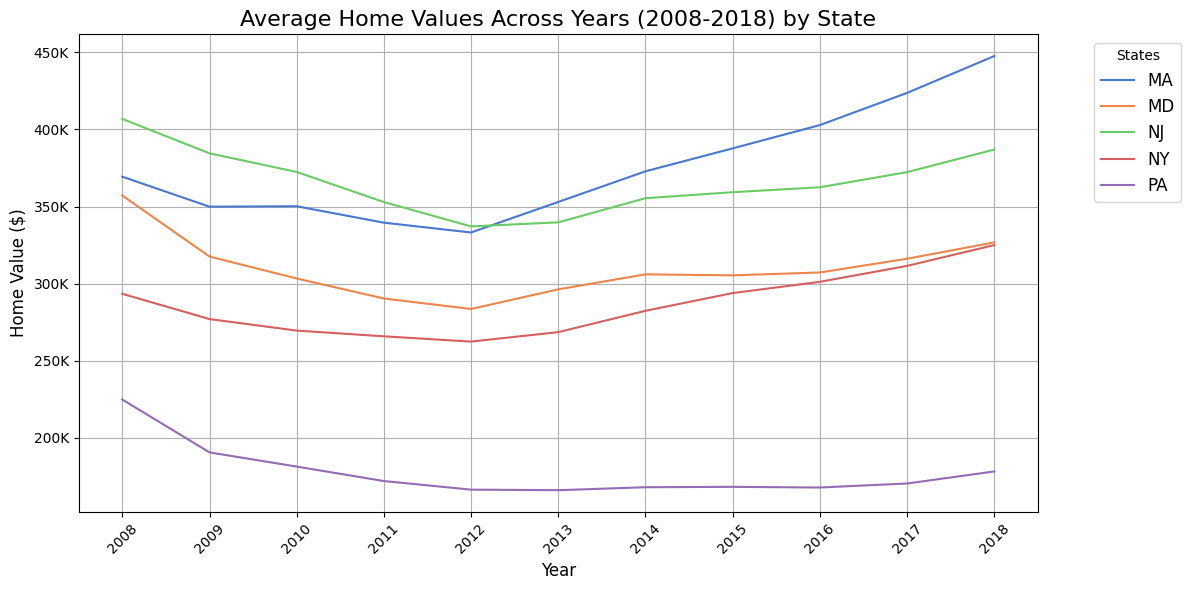

In [121]:
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

# Plot the precipitation data
fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette("muted", len(state_home_values.columns))

#Data frame to plot : state_home_values
for i, state in enumerate(state_home_values.columns):
    ax.plot(state_home_values.index, state_home_values[state], label=state, color=colors[i])

# Set title and axis labels
ax.set_title('Average Home Values Across Years (2008-2018) by State', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Home Value ($)', fontsize=12)
ax.grid(True)  # Enable grid on the axes

ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Every 5 year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 4-digit year format

#Rotate for readability
plt.tick_params(axis='x', rotation=90)

ax.xaxis.set_minor_locator(mdates.YearLocator(1))  # Every 1 year
# ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y'))  # 4-digit year format
# plt.tick_params(axis='x', rotation=90)

# Format the y-axis to display values in thousands (K)
formatter = FuncFormatter(lambda x, pos: f'{int(x/1000)}K')
ax.yaxis.set_major_formatter(formatter)

# Add a legend
ax.legend(title='States', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Set limits to remove gap before the first data point
# ax.set_xlim(left=state_home_values.index[0])  # Remove gap before the first year

# Format the plot for better visibility
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

>Legend Explained:

- MA (Massachusetts): Blue line

- MD (Maryland): Orange line

- NJ (New Jersey): Green line

- NY (New York): Red line

- PA (Pennsylvania): Purple line

> **The Great Recession** was a period of market decline in economies around the world that occurred from late 2007 to mid-2009. {Dec 2007 - June 2009} [ref:https://en.wikipedia.org/wiki/Great_Recession]
This Recession effect on Real Estate Sector leads to a reduced level of real estate activity, as fewer people are willing or able to buy properties.

> The graph represents the years from 2008 to 2018, showing the timeline over which home values are plotted for five different states.<br/> The home values in thousands of dollars, ranging from approximately 200K to 450K. The values represent the average home prices for each state for that year.<br/>

### General Trends:

- >Massachusetts (MA) shows a steady increase in home values over the years, consistently rising.

- >New Jersey (NJ) and Maryland (MD) also show upward trends, though the increases seem more gradual compared to Massachusetts.

- >New York (NY) and Pennsylvania (PA) exhibit slower increases in home values, with some fluctuation in the middle of the time period (around 2012–2014).

### Specific Explanation for each State:<br/>

1- Massachusetts (MA) Steady Increase in Home Values
> ***2008–2011:*** Home values initially decline slightly during the Great Recession period (2008-2011) but then show strong growth after 2012.<br/>
***2012–2018:*** The most significant growth is observed in this period, with home values consistently rising. Massachusetts had a substantial recovery after the housing crash, indicating a strong real estate market in the state during the 2010s.

2- Maryland (MD) Slow but Steady Increase
> ***2008–2012:*** The home values in Maryland were somewhat stable but had a minor dip in the early part of the period, likely due to the financial crisis. <br/> ***2012–2018:*** After 2012, Maryland’s home values started to grow more steadily, though not as aggressively as in Massachusetts. It appears that Maryland had a more balanced but consistent recovery in the housing market.

3- New Jersey (NJ) Moderate Growth with Fluctuations
> ***2008–2011:*** Similar to Massachusetts and Maryland, New Jersey saw a sharp decline in home values during the recession, but its recovery seems a bit more gradual, with some plateauing in the early years post-2010. <br/> ***2012–2018:*** The growth becomes more evident after 2012, but New Jersey’s home values continue to have slower growth compared to the other states. This could suggest a more stable and conservative real estate market in New Jersey during this period.

4- New York (NY) Fluctuations with Slow Growth
> ***2008–2013:*** New York was significantly impacted by the 2008 financial crisis, and home values fluctuated within a narrow range. <br/>
***2014–2018:*** After 2013, New York experienced a relatively slow and steady increase in home values, but it was less pronounced than Massachusetts or Maryland. This might suggest that New York’s real estate market was more sluggish or that recovery took longer in some parts of the state.

5- Pennsylvania (PA) Stable but Slow Growth
> With Pennsylvania (PA) showing a dramatic drop in house values in 2008 and a steady drop from 2009 - 2012, and a slight slow and steady, increase from 2017 - 2018 compared to previous years. <br/>
***2008–2013:*** Home values in Pennsylvania dipped during the recession but didn’t experience as sharp a decline as other states.<br/>
***2013–2018:*** The growth in home values remained slow and steady, with the purple line consistently trailing behind the other states. This could reflect a more conservative or stagnant market in Pennsylvania compared to the other states.

# Part 2